# Project 7 - Notes for choosing hyperparameter for text input

**Author: Linh Nguyen**<br>

**StudentID: 23161711**<br>

**Date: Sep 2022**

## 1. Load data and import package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone_project

Mounted at /content/drive
/content/drive/MyDrive/Capstone_project


In [ ]:
import numpy as np
import pandas as pd
import re
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import  tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score

In [ ]:
! ls /content/drive/MyDrive/Capstone_project/raw

diagnosis.csv  icd9toicd10cmgem.csv  pyxis.csv	 vitalsign.csv
edstays.csv    medrecon.csv	     triage.csv


In [ ]:
triage = pd.read_csv('raw/triage.csv')

In [ ]:
edstays = pd.read_csv('raw/edstays.csv')
edstays['y_var_adm_text'] = edstays['disposition']
edstays.loc[edstays['y_var_adm_text'] == 'TRANSFER', 'y_var_adm_text'] = 'ADMITTED'
edstays.loc[edstays['y_var_adm_text'] == 'ELOPED','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT WITHOUT BEING SEEN','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'OTHER','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT AGAINST MEDICAL ADVICE','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'EXPIRED','y_var_adm_text'] = 'MISSING'
edstays_admit = edstays[edstays['y_var_adm_text'] !='MISSING'].reset_index(drop = True)
edstays_admit['key'] = edstays_admit['subject_id'].astype(str)+'_'+edstays_admit['stay_id'].astype(str)

In [ ]:
triage_1 = pd.merge(edstays_admit[['subject_id', 'stay_id','y_var_adm_text']],triage,how = 'left',on=['subject_id', 'stay_id'])

In [ ]:
triage_1['y_var'] = 0
triage_1.loc[triage_1['y_var_adm_text'] == 'ADMITTED', 'y_var']  = 1

In [ ]:
triage_2 = triage_1[['subject_id','stay_id', 'y_var','chiefcomplaint']]

In [ ]:
triage_2[triage_2.y_var.isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [ ]:
triage_2[triage_2.chiefcomplaint.isna()]

,subject_id,stay_id,y_var,chiefcomplaint
209834,14913519,33280070,1,NaN
219040,15127661,39766508,1,NaN
230046,15376111,34216718,1,NaN
241580,15632852,37860864,0,NaN
307992,17192157,31192693,0,NaN
322362,17526143,30744048,1,NaN
356784,18321345,37024607,1,NaN
360935,18425846,33948058,1,NaN


In [ ]:
triage_2.loc[triage_2['chiefcomplaint'].isna(),'chiefcomplaint'] = ''

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
triage_2[triage_2['chiefcomplaint'].isna()]

,subject_id,stay_id,y_var,chiefcomplaint


In [ ]:
# Preprocess the job_description (remove the weird part of strings)
def preprocess_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
triage_2.chiefcomplaint = triage_2.chiefcomplaint.apply(preprocess_text)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_pre_icd_full = pd.read_csv('previous_icd_code.csv')

triage_3 = pd.merge(triage_2,df_pre_icd_full, how = "left",on=['subject_id', 'stay_id'])

In [ ]:
triage_3

,subject_id,stay_id,y_var,chiefcomplaint,Unnamed: 0,key,fin_code_group,hadm_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,pre_icd_code
0,10000032,33258284,1,"abd pain , abdominal distention",0,10000032_33258284,"['K72', 'R18', '707', 'Z21']",22595853.0,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,NaN
1,10000032,38112554,1,abdominal distention,1,10000032_38112554,"['R18', '707', 'K74', 'Z21']",22841357.0,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"K72,R18,707,Z21"
2,10000032,35968195,1,"n v d , abd pain",4,10000032_35968195,"['K74', 'R10', 'Z21']",25742920.0,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"R41,G93"
3,10000032,32952584,0,hypotension,2,10000032_32952584,"['I95', '707', 'Z21']",29079034.0,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,HOME,"R18,707,K74,Z21"
4,10000032,39399961,1,"abdominal distention , abd pain , lethagic",3,10000032_39399961,"['R41', 'G93']",29079034.0,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"I95,707,Z21"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428279,19999784,34149746,1,wound eval,428280,19999784_34149746,"['G97', 'G96', 'Y83', 'Y92']",25715748.0,2119-08-11 09:15:00,2119-08-11 13:40:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,R53
428280,19999784,35692999,1,l leg weakness,428278,19999784_35692999,['R53'],26194817.0,2119-06-18 14:21:00,2119-06-18 21:09:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,NaN
428281,19999828,32917002,1,"abd pain , wound eval",428282,19999828_32917002,"['E11', 'Z79']",25744818.0,2149-01-08 09:11:00,2149-01-08 18:12:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,K63
428282,19999828,30712109,1,"abd pain , wound eval",428281,19999828_30712109,['K63'],29734428.0,2147-07-17 17:18:00,2147-07-18 17:34:00,F,WHITE,WALK IN,ADMITTED,ADMITTED,NaN


# 2. Text data overview

In [ ]:
def print_plot_length(df,x_var,y_var):
    def calculate_length(x):
        if type(x) == float:
            if x > 0:
                r = len(x.replace(',',' ').split())
            else: r = 0
        else:
            r = len(x.replace(',',' ').split())
        
        return(r)
    df['length'] = df[x_var].apply(calculate_length)
    positive_lengths = df[df[y_var]==1]['length']
    negative_lengths = df[df[y_var]==0]['length']
    plt.figure(figsize=(15,5))
    plt.title(x_var + ' length distribution')
    sns.distplot(negative_lengths, kde=False)
    sns.distplot(positive_lengths, kde=False)
    plt.legend(['home', 'admitted'])
    plt.xlabel('no of words')
    plt.ylabel('no of observations')
    plt.grid(False)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


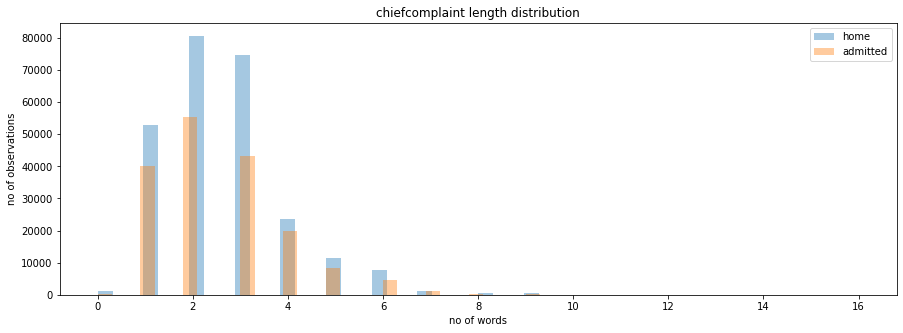

In [ ]:
print_plot_length(triage_3,'chiefcomplaint','y_var')

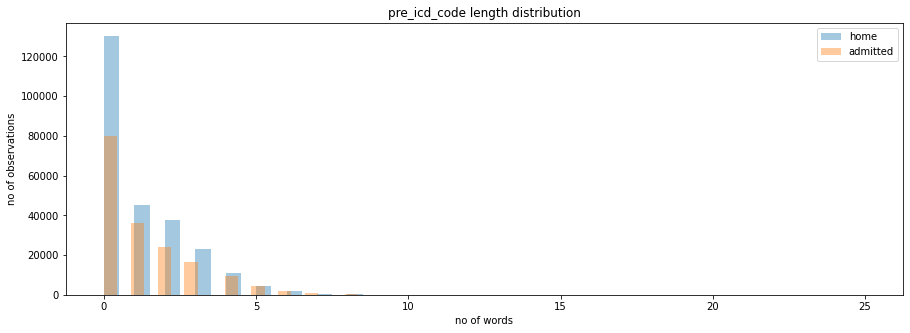

In [ ]:
print_plot_length(triage_3,'pre_icd_code','y_var')

In [ ]:
# 2. Split the dataset

In [ ]:
#set random index, create train set and validation set from the original train set

#create array of random index
np.random.seed(123)
ind = np.arange(len(triage_3))
np.random.shuffle(ind)
#create testing index  = 0 to 0.20 * random index
test_index = ind[:int(len(triage_3) * 0.20)]
#create train index = 0.20 * random index to end
train_index = ind[int(len(triage_3) * 0.20):]

In [ ]:
train_samples_chief =  triage_3.chiefcomplaint[train_index]
train_samples_his =  triage_3.pre_icd_code[train_index]
test_samples_chief =  triage_3.chiefcomplaint[test_index]
test_samples_his =  triage_3.pre_icd_code[test_index]
train_labels =  triage_3.y_var[train_index]
test_labels = triage_3.y_var[test_index]

# 3. Embedding for chief complaint and historical icd code

### 3.1 Embedding for chief complaint

In [ ]:
vectorizer = TextVectorization(output_sequence_length=5)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples_chief).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
#print top 5 words
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'pain', 'abd', 'l']

In [ ]:
#example of vectorizing a sentences:
output = vectorizer([["Abd pain, Wound eval"]])
output.numpy()[0, :6]

array([ 3,  2, 28, 20,  0])

In [ ]:
#build vocabulary dictionary for chief complaint:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
#load the model w2vec for chief complaint:
model_w2v = KeyedVectors.load_word2vec_format('W2vec/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v.get_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        initializer = tf.keras.initializers.GlorotNormal(seed = 123)
        values = initializer(shape=(1, 200))
        embedding_matrix[i] = values
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4441 words (178 misses)


In [ ]:
#create embedding layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### 3.2 Embedding for historical icd code group

In [ ]:
his_icd_top198 = pd.read_csv('top198historical_icd.csv')

In [ ]:
vectorizer_his = TextVectorization(output_sequence_length=5)
text_ds_his = tf.data.Dataset.from_tensor_slices(his_icd_top198['icd_group']).batch(128)
vectorizer_his.adapt(text_ds_his)

In [ ]:
#top 5 icd:

vectorizer_his.get_vocabulary()[:5]

['', '[UNK]', 'z99', 'z95', 'z94']

In [ ]:
voc_his = vectorizer_his.get_vocabulary()
word_index_his = dict(zip(voc_his, range(len(voc_his))))
num_tokens_his = len(voc_his) + 2
embedding_dim_his = 200


# Prepare embedding matrix (create one hot encoding matrix for historical icd code)
embedding_matrix_his = np.zeros((num_tokens_his, embedding_dim_his))
for word, i in word_index_his.items():
    embedding_vector = np.zeros(embedding_dim_his)
    embedding_vector[vectorizer_his([word]).numpy()[0][0]] = 1
    embedding_matrix_his[i] = embedding_vector

In [ ]:
embedding_layer_his = Embedding(
    num_tokens_his,
    embedding_dim_his,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_his),
    trainable=False,
)

### 3.3 Concat 2 embedding

In [ ]:
#tf.concat([embedding_layer(x_train[0]),[embedding_layer_his(x_train[0])]],0)

# 4 BiLSTM model using historical and current data (historical icd code & chief complaint)

In [ ]:
!pip install --quiet optuna

     |████████████████████████████████| 348 kB 12.5 MB/s 
     |████████████████████████████████| 81 kB 9.3 MB/s 
     |████████████████████████████████| 209 kB 57.0 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 147 kB 68.8 MB/s 
     |████████████████████████████████| 112 kB 61.7 MB/s 


In [ ]:
RANDOM_SEED = 42
from sklearn.model_selection import KFold
import optuna

# 5-fold CV
kfolds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params




In [ ]:
x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
x_train_his = vectorizer_his(np.array([[s] for s in train_samples_his])).numpy()

In [ ]:
x_train.shape

(342628, 5)

In [ ]:
x_train_his.shape

(342628, 5)

In [ ]:
x_train.shape

(342628, 5)

In [ ]:
keras.layers.Concatenate(axis=1)([embedding_layer(x_train)[:2], embedding_layer_his(x_train_his)[:2]])

<tf.Tensor: shape=(2, 10, 200), dtype=float32, numpy=
array([[[-0.14429 ,  0.47702 , -0.31244 , ..., -0.012517, -0.8851  ,
          0.22914 ],
        [-0.26031 ,  0.4272  ,  0.30948 , ...,  0.12645 , -0.17008 ,
         -0.3857  ],
        [ 0.10894 ,  0.6511  , -0.45509 , ...,  0.23647 , -0.030245,
          0.22282 ],
        ...,
        [ 1.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 1.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 1.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]],

       [[-0.069004,  0.72303 , -0.22993 , ...,  1.1647  , -0.87863 ,
         -0.74303 ],
        [ 0.10894 ,  0.6511  , -0.45509 , ...,  0.23647 , -0.030245,
          0.22282 ],
        [-0.15709 ,  0.4576  ,  0.35396 , ..., -0.20872 , -0.64504 ,
         -0.29215 ],
        ...,
        [ 1.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 1.      

In [ ]:
# K-fold Cross Validation model evaluation


x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
x_train_his = vectorizer_his(np.array([[s] for s in train_samples_his])).numpy()
y_train = np.array(train_labels)


def BiLSTM(trial):
    units = trial.suggest_int("units", 100, 200)
    activation = trial.suggest_categorical("activation", ['tanh', 'relu'])
    optimizer = trial.suggest_categorical("optimizer", ['adam', 'rmsprop'])
    dropout_rate = trial.suggest_int("rate", 0.2, 0.5)
    col1 = keras.Input(shape = (5,))
    embedded_sequences1 = embedding_layer_his(col1)
    col2 = keras.Input(shape = (5,))
    embedded_sequences2 = embedding_layer(col2)

    embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
    x = keras.layers.Bidirectional(keras.layers.LSTM(units, return_sequences=True, activation = activation))(embedded_sequences)
    x = keras.layers.Bidirectional(keras.layers.LSTM(units, activation = activation))(x)
    x = keras.layers.Dense(units/2,activation = activation)(x)
    x = keras.layers.Dropout(rate = dropout_rate)(x)
    preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
    model = keras.models.Model(inputs = [col1,col2], outputs = preds)
    weights = [1-(sum(train_labels)/len(train_labels)),sum(train_labels)/len(train_labels)]

    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, loss_weights = weights, metrics = "accuracy")
    acc_per_fold = []
    loss_per_fold = []
    early = EarlyStopping(monitor='loss', patience=5)
    for train, test in kfolds.split(x_train, y_train):
        model.fit(x=[x_train_his[train],x_train[train]], y = y_train[train],batch_size=256, epochs=100, callbacks=[early])

  # Generate generalization metrics
        scores = model.evaluate([x_train_his[test],x_train[test]], y_train[test])
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
    
    return np.mean(acc_per_fold)

LSTM_params = tune(BiLSTM)

[I 2022-09-05 09:41:28,627] A new study created in memory with name: no-name-17f30ef0-73f4-4911-bd92-ea7ba4f957f7


Epoch 1/100
1071/1071 [==============================] - 32s 17ms/step - loss: 0.3238 - accuracy: 0.7247
Epoch 2/100
1071/1071 [==============================] - 19s 18ms/step - loss: 0.3152 - accuracy: 0.7339
Epoch 3/100
1071/1071 [==============================] - 18s 17ms/step - loss: 0.3128 - accuracy: 0.7365
Epoch 4/100
1071/1071 [==============================] - 18s 17ms/step - loss: 0.3112 - accuracy: 0.7381
Epoch 5/100
1071/1071 [==============================] - 18s 17ms/step - loss: 0.3100 - accuracy: 0.7390
Epoch 6/100
1071/1071 [==============================] - 18s 17ms/step - loss: 0.3088 - accuracy: 0.7401
Epoch 7/100
1071/1071 [==============================] - 18s 17ms/step - loss: 0.3079 - accuracy: 0.7415
Epoch 8/100
1071/1071 [==============================] - 18s 17ms/step - loss: 0.3069 - accuracy: 0.7427
Epoch 9/100
1071/1071 [==============================] - 18s 17ms/step - loss: 0.3058 - accuracy: 0.7435
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-05 10:54:32,862] Trial 0 finished with value: 75.34323692321777 and parameters: {'units': 138, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.


Epoch 1/100
1071/1071 [==============================] - 27s 18ms/step - loss: 0.3264 - accuracy: 0.7219
Epoch 2/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3156 - accuracy: 0.7337
Epoch 3/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3129 - accuracy: 0.7370
Epoch 4/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3112 - accuracy: 0.7387
Epoch 5/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3098 - accuracy: 0.7392
Epoch 6/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3087 - accuracy: 0.7410
Epoch 7/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3074 - accuracy: 0.7419
Epoch 8/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3063 - accuracy: 0.7434
Epoch 9/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3053 - accuracy: 0.7437
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-05 12:13:13,819] Trial 1 finished with value: 74.89143490791321 and parameters: {'units': 144, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.


Epoch 1/100
1071/1071 [==============================] - 158s 143ms/step - loss: 0.3213 - accuracy: 0.7259
Epoch 2/100
1071/1071 [==============================] - 152s 142ms/step - loss: 0.3130 - accuracy: 0.7366
Epoch 3/100
1071/1071 [==============================] - 151s 141ms/step - loss: 0.3110 - accuracy: 0.7386
Epoch 4/100
1071/1071 [==============================] - 152s 142ms/step - loss: 0.3093 - accuracy: 0.7398
Epoch 5/100
1071/1071 [==============================] - 152s 142ms/step - loss: 0.3081 - accuracy: 0.7413
Epoch 6/100
1071/1071 [==============================] - 152s 142ms/step - loss: 0.3068 - accuracy: 0.7423
Epoch 7/100
1071/1071 [==============================] - 151s 141ms/step - loss: 0.3056 - accuracy: 0.7432
Epoch 8/100
1071/1071 [==============================] - 151s 141ms/step - loss: 0.3047 - accuracy: 0.7443
Epoch 9/100
1071/1071 [==============================] - 152s 142ms/step - loss: 0.3031 - accuracy: 0.7456
Epoch 10/100
1071/1071 [=============

[I 2022-09-05 17:05:42,014] Trial 2 finished with value: 65.2436101436615 and parameters: {'units': 174, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.


Epoch 1/100
1071/1071 [==============================] - 27s 19ms/step - loss: 0.3258 - accuracy: 0.7232
Epoch 2/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3156 - accuracy: 0.7337
Epoch 3/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3129 - accuracy: 0.7369
Epoch 4/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3112 - accuracy: 0.7379
Epoch 5/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3097 - accuracy: 0.7399
Epoch 6/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3085 - accuracy: 0.7406
Epoch 7/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3074 - accuracy: 0.7416
Epoch 8/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3062 - accuracy: 0.7431
Epoch 9/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3051 - accuracy: 0.7443
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-05 18:30:42,590] Trial 3 finished with value: 74.77410554885864 and parameters: {'units': 147, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.


Epoch 1/100
1071/1071 [==============================] - 144s 130ms/step - loss: 0.3238 - accuracy: 0.7244
Epoch 2/100
1071/1071 [==============================] - 140s 131ms/step - loss: 0.3148 - accuracy: 0.7357
Epoch 3/100
1071/1071 [==============================] - 139s 130ms/step - loss: 0.3128 - accuracy: 0.7374
Epoch 4/100
1071/1071 [==============================] - 139s 129ms/step - loss: 0.3132 - accuracy: 0.7386
Epoch 5/100
1071/1071 [==============================] - 138s 129ms/step - loss: 0.3454 - accuracy: 0.7386
Epoch 6/100
1071/1071 [==============================] - 138s 129ms/step - loss: 0.6993 - accuracy: 0.7387
Epoch 7/100
1071/1071 [==============================] - 138s 129ms/step - loss: 0.3886 - accuracy: 0.7370
Epoch 8/100
2142/2142 [==============================] - 24s 11ms/step - loss: 0.3195 - accuracy: 0.7218
Epoch 1/100
1071/1071 [==============================] - 137s 128ms/step - loss: 1.2913 - accuracy: 0.7214
Epoch 2/100
1071/1071 [================

[I 2022-09-05 20:52:38,529] Trial 4 finished with value: 61.9660222530365 and parameters: {'units': 104, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.


Epoch 1/100
1071/1071 [==============================] - 24s 17ms/step - loss: 0.3236 - accuracy: 0.7248
Epoch 2/100
1071/1071 [==============================] - 18s 16ms/step - loss: 0.3152 - accuracy: 0.7342
Epoch 3/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3129 - accuracy: 0.7363
Epoch 4/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3115 - accuracy: 0.7379
Epoch 5/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3103 - accuracy: 0.7386
Epoch 6/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3091 - accuracy: 0.7398
Epoch 7/100
1071/1071 [==============================] - 18s 16ms/step - loss: 0.3082 - accuracy: 0.7407
Epoch 8/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3071 - accuracy: 0.7418
Epoch 9/100
1071/1071 [==============================] - 18s 16ms/step - loss: 0.3061 - accuracy: 0.7430
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-05 22:10:09,662] Trial 5 finished with value: 75.40306687355042 and parameters: {'units': 119, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 5 with value: 75.40306687355042.


Epoch 1/100
1071/1071 [==============================] - 142s 128ms/step - loss: 0.3235 - accuracy: 0.7258
Epoch 2/100
1071/1071 [==============================] - 136s 127ms/step - loss: 0.3150 - accuracy: 0.7355
Epoch 3/100
1071/1071 [==============================] - 137s 127ms/step - loss: 0.3149 - accuracy: 0.7372
Epoch 4/100
1071/1071 [==============================] - 137s 128ms/step - loss: 0.3302 - accuracy: 0.7377
Epoch 5/100
1071/1071 [==============================] - 137s 128ms/step - loss: 0.9225 - accuracy: 0.7382
Epoch 6/100
1071/1071 [==============================] - 136s 127ms/step - loss: 2.2841 - accuracy: 0.7380
Epoch 7/100
1071/1071 [==============================] - 137s 127ms/step - loss: 3.7789 - accuracy: 0.7375
Epoch 8/100
2142/2142 [==============================] - 25s 11ms/step - loss: 0.3284 - accuracy: 0.7269
Epoch 1/100
1071/1071 [==============================] - 137s 128ms/step - loss: 0.5751 - accuracy: 0.7337
Epoch 2/100
1071/1071 [================

[I 2022-09-06 00:31:18,917] Trial 6 finished with value: 64.69491362571716 and parameters: {'units': 108, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 5 with value: 75.40306687355042.


Epoch 1/100
1071/1071 [==============================] - 23s 16ms/step - loss: 0.3236 - accuracy: 0.7247
Epoch 2/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3151 - accuracy: 0.7341
Epoch 3/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3129 - accuracy: 0.7364
Epoch 4/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3114 - accuracy: 0.7374
Epoch 5/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3100 - accuracy: 0.7390
Epoch 6/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3091 - accuracy: 0.7401
Epoch 7/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3081 - accuracy: 0.7405
Epoch 8/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3070 - accuracy: 0.7416
Epoch 9/100
1071/1071 [==============================] - 17s 16ms/step - loss: 0.3061 - accuracy: 0.7430
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-06 01:46:46,132] Trial 7 finished with value: 75.46523213386536 and parameters: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 7 with value: 75.46523213386536.


Epoch 1/100
1071/1071 [==============================] - 147s 133ms/step - loss: 0.3216 - accuracy: 0.7262
Epoch 2/100
1071/1071 [==============================] - 142s 132ms/step - loss: 0.3132 - accuracy: 0.7365
Epoch 3/100
1071/1071 [==============================] - 142s 133ms/step - loss: 0.3109 - accuracy: 0.7387
Epoch 4/100
1071/1071 [==============================] - 142s 133ms/step - loss: 0.3094 - accuracy: 0.7405
Epoch 5/100
1071/1071 [==============================] - 142s 132ms/step - loss: 0.3080 - accuracy: 0.7416
Epoch 6/100
1071/1071 [==============================] - 142s 132ms/step - loss: 0.3072 - accuracy: 0.7427
Epoch 7/100
1071/1071 [==============================] - 141s 132ms/step - loss: 0.3058 - accuracy: 0.7439
Epoch 8/100
1071/1071 [==============================] - 141s 131ms/step - loss: 0.3046 - accuracy: 0.7451
Epoch 9/100
1071/1071 [==============================] - 142s 132ms/step - loss: 0.3035 - accuracy: 0.7457
Epoch 10/100
1071/1071 [=============

[I 2022-09-06 07:32:57,321] Trial 8 finished with value: 65.02092242240906 and parameters: {'units': 137, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 7 with value: 75.46523213386536.


Epoch 1/100
1071/1071 [==============================] - 26s 18ms/step - loss: 0.3265 - accuracy: 0.7217
Epoch 2/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3157 - accuracy: 0.7337
Epoch 3/100
1071/1071 [==============================] - 19s 18ms/step - loss: 0.3128 - accuracy: 0.7365
Epoch 4/100
1071/1071 [==============================] - 20s 19ms/step - loss: 0.3111 - accuracy: 0.7382
Epoch 5/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3098 - accuracy: 0.7398
Epoch 6/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3085 - accuracy: 0.7407
Epoch 7/100
1071/1071 [==============================] - 19s 18ms/step - loss: 0.3074 - accuracy: 0.7413
Epoch 8/100
1071/1071 [==============================] - 20s 18ms/step - loss: 0.3063 - accuracy: 0.7436
Epoch 9/100
1071/1071 [==============================] - 19s 18ms/step - loss: 0.3053 - accuracy: 0.7442
Epoch 10/100
1071/1071 [==============================]

[I 2022-09-06 08:48:47,708] Trial 9 finished with value: 74.83335375785828 and parameters: {'units': 148, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 7 with value: 75.46523213386536.


Best score: 75.46523213386536

Optimized parameters: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}



In [ ]:
x_train = vectorizer(np.array([[s] for s in train_samples_chief])).numpy()
x_train_his = vectorizer(np.array([[s] for s in train_samples_his])).numpy()

[I 2022-09-05 10:54:32,862] Trial 0 finished with value: 75.34323692321777 and parameters: {'units': 138, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.


[I 2022-09-05 12:13:13,819] Trial 1 finished with value: 74.89143490791321 and parameters: {'units': 144, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.

[I 2022-09-05 17:05:42,014] Trial 2 finished with value: 65.2436101436615 and parameters: {'units': 174, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.

[I 2022-09-05 18:30:42,590] Trial 3 finished with value: 74.77410554885864 and parameters: {'units': 147, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.

[I 2022-09-05 20:52:38,529] Trial 4 finished with value: 61.9660222530365 and parameters: {'units': 104, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 0 with value: 75.34323692321777.
Epoch 1/100

[I 2022-09-05 22:10:09,662] Trial 5 finished with value: 75.40306687355042 and parameters: {'units': 119, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 5 with value: 75.40306687355042.

[I 2022-09-06 00:31:18,917] Trial 6 finished with value: 64.69491362571716 and parameters: {'units': 108, 'activation': 'relu', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 5 with value: 75.40306687355042.

[I 2022-09-06 01:46:46,132] Trial 7 finished with value: 75.46523213386536 and parameters: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}. Best is trial 7 with value: 75.46523213386536.

[I 2022-09-06 07:32:57,321] Trial 8 finished with value: 65.02092242240906 and parameters: {'units': 137, 'activation': 'relu', 'optimizer': 'adam', 'rate': 0}. Best is trial 7 with value: 75.46523213386536.

[I 2022-09-06 08:48:47,708] Trial 9 finished with value: 74.83335375785828 and parameters: {'units': 148, 'activation': 'tanh', 'optimizer': 'rmsprop', 'rate': 0}. Best is trial 7 with value: 75.46523213386536.
Best score: 75.46523213386536

Optimized parameters: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}